In [133]:
%config IPCompleter.greedy=True
%matplotlib inline
import string
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import math
import warnings

from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf

# Display preferences.
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# The Data: Gender Achievement Gaps in U.S. School Districts. Reardon, S.F., Fahle, E.M., Kalogrides, D., Podolsky, A., & Zárate, R.C. 

[See the NYT ARTICLE](https://www.nytimes.com/interactive/2018/06/13/upshot/boys-girls-math-reading-tests.html)

In [48]:
df = pd.read_csv('seda_gender_achievement_gaps_june2018.csv')

In [49]:
df

,NCES District ID,LEA Name,Fips State Code,State Abbreviation,Average Number of Students in a Grade-Subject-Year,Average Number of Students in a Gender-Grade-Subject-Year,EB Male-Female Math Achievement Gap (SD Units),EB Male-Female ELA Achievement Gap (SD Units),EB Standard Error of Male-Female Math Achievement Gap (SD Units),EB Standard Error of Male-Female ELA Achievement Gap (SD Units),...,Male-Female SES Composite Difference,Income at 50th percentile - All Adults,Income at 50th percentile - Female Adults,Income at 50th percentile - Male Adults,Male-Female Income V-Gap,Percent of Black Students in District,Percent of Hispanic Students in District,Percent of Other Race Students in District,Percent of White Students in District,Reliable District Gap Estimate; District has >200 Male/Female Students per Grade
0,100005,Albertville City,1,AL,325,162,0.022,-0.214,0.019,0.022,...,0.503,40625.000,16791.000,22031.000,0.336,0.021,0.360,0.007,0.613,0
1,100006,Marshall County,1,AL,430,215,-0.014,-0.277,0.018,0.022,...,1.157,46291.000,18801.000,29471.000,0.536,0.010,0.153,0.005,0.832,1
2,100007,Hoover City,1,AL,1029,514,0.092,-0.199,0.017,0.020,...,1.752,91103.000,30829.000,49896.000,0.541,0.238,0.058,0.068,0.636,1
3,100008,Madison City,1,AL,691,346,0.068,-0.245,0.019,0.022,...,3.459,103228.000,30709.000,70076.000,0.751,0.203,0.034,0.093,0.670,1
4,100011,Leeds City,1,AL,126,63,0.034,-0.232,0.024,0.028,...,1.520,53000.000,19138.000,33434.000,0.535,0.244,0.121,0.011,0.624,0
5,100012,Boaz City,1,AL,169,84,0.089,-0.182,0.022,0.026,...,1.761,46562.000,16587.000,28022.000,0.506,0.017,0.194,0.012,0.777,0
6,100013,Trussville City,1,AL,329,165,0.076,-0.188,0.020,0.023,...,1.152,95999.000,39600.000,55007.000,0.532,0.101,0.008,0.026,0.866,0
7,100030,Alexander City,1,AL,243,121,0.015,-0.227,0.020,0.023,...,0.944,48382.000,21623.000,25671.000,0.193,0.383,0.028,0.009,0.580,0
8,100060,Andalusia City,1,AL,131,66,0.029,-0.234,0.024,0.028,...,1.384,29772.000,14959.000,22975.000,0.470,0.335,0.018,0.015,0.632,0
9,100090,Anniston City,1,AL,163,82,-0.059,-0.272,0.020,0.024,...,1.253,31800.000,17651.000,24691.000,0.380,0.921,0.021,0.003,0.054,0


In [57]:
df = df.rename(lambda c: c.replace(' ', '_').replace('-', '').replace('(', '').replace(')', ''), axis='columns')

In [58]:
df.columns

Index(['NCES_District_ID', 'LEA_Name', 'Fips_State_Code', 'State_Abbreviation',
       'Average_Number_of_Students_in_a_GradeSubjectYear',
       'Average_Number_of_Students_in_a_GenderGradeSubjectYear',
       'EB_MaleFemale_Math_Achievement_Gap_SD_Units',
       'EB_MaleFemale_ELA_Achievement_Gap_SD_Units',
       'EB_Standard_Error_of_MaleFemale_Math_Achievement_Gap_SD_Units',
       'EB_Standard_Error_of_MaleFemale_ELA_Achievement_Gap_SD_Units',
       'EB_MaleFemale_Math_Achievement_Gap_Grade_Equivalent_Units',
       'EB_MaleFemale_ELA_Achievement_Gap_Grade_Equivalent_Units',
       'EB_Standard_Error_of_MaleFemale_Math_Achievement_Gap_Grade_Equivalent_Units',
       'EB_Standard_Error_of_MaleFemale_ELA_Achievement_Gap_Grade_Equivalent_Units',
       'SES_Composite__All_Adults', 'SES_Composite__Female_Adults',
       'SES_Composite__Male_Adults', 'MaleFemale_SES_Composite_Difference',
       'Income_at_50th_percentile__All_Adults',
       'Income_at_50th_percentile__Female_Adults

In [74]:
is_reliable = 'Reliable_District_Gap_Estimate;_District_has_>200_Male/Female_Students_per_Grade'
df = df[df[is_reliable] == 1]

In [104]:
math_gap = 'EB_MaleFemale_Math_Achievement_Gap_SD_Units'
f = {
'pop': 'Average_Number_of_Students_in_a_GradeSubjectYear',
'income': 'SES_Composite__All_Adults',
'percent_white': 'Percent_of_White_Students_in_District',
'gender_income_gap': 'MaleFemale_Income_VGap',
}

In [105]:
features = np.array(list(f.values()))
features

array(['Average_Number_of_Students_in_a_GradeSubjectYear',
       'SES_Composite__All_Adults',
       'Percent_of_White_Students_in_District', 'MaleFemale_Income_VGap'],
      dtype='<U48')

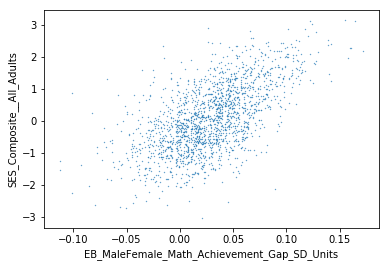

In [106]:
df.plot.scatter(math_gap, f['income'], s=0.1)

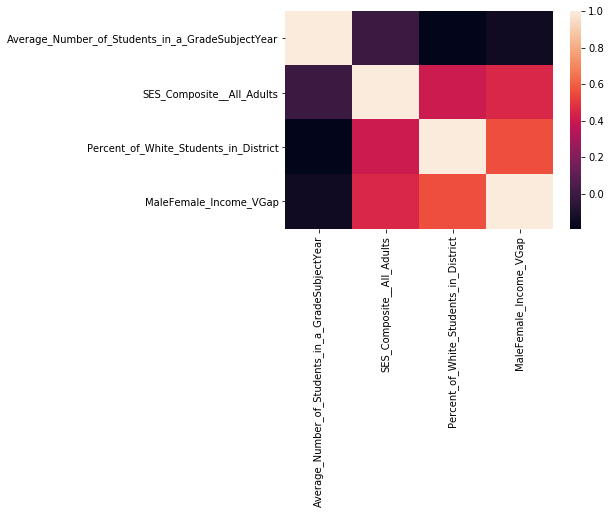

In [107]:
sns.heatmap(df[features].corr())
plt.show()

# OLS Model

In [108]:
def create_lm(linear_formula, df):
    lm = smf.ols(formula=linear_formula, data=df).fit()
    print(f'\nParams:\n {lm.params}')
    print(f'\nPvalues:\n {lm.pvalues}')
    print(f'\nR^2:\n {lm.rsquared}')
    return lm

lm_features = '+'.join(features) # {income}+{percent_white}+{gender_income_gap}
linear_formula = f'{math_gap} ~ {lm_features}'
create_lm(linear_formula, df)


Params:
 Intercept                                          -0.006
Average_Number_of_Students_in_a_GradeSubjectYear   -0.000
SES_Composite__All_Adults                           0.017
Percent_of_White_Students_in_District               0.016
MaleFemale_Income_VGap                              0.057
dtype: float64

Pvalues:
 Intercept                                          0.023
Average_Number_of_Students_in_a_GradeSubjectYear   0.002
SES_Composite__All_Adults                          0.000
Percent_of_White_Students_in_District              0.000
MaleFemale_Income_VGap                             0.000
dtype: float64

R^2:
 0.4449037558716703


# KNN

In [132]:
def test_KNNs(k, scores, std, scores_w, std_w, X, Y, print_info=False):
    # un=weighted.
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(X, Y)
    # weighted.
    knn_w = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_w.fit(X, Y)

    # EVAL
    score = cross_val_score(knn, X, Y, cv=5)
    score_w = cross_val_score(knn_w, X, Y, cv=5)
    if print_info:
        print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
        print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))
    scores += [abs(score.mean())]
    std += [abs(score.std())]
    scores_w += [abs(score_w.mean())]
    std_w += [abs(score_w.std())]

## Identify optimal K value

In [135]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_ages = scaler.fit_transform(df[f['income']].reshape(-1, 1))
print(scaled_ages)

AttributeError: 'Series' object has no attribute 'reshape'

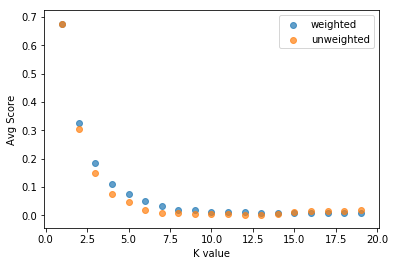

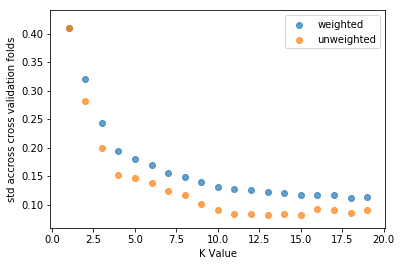

In [131]:
scores = []
scores_w = []
std = []
std_w = []
X = df[features]
Y = df[math_gap]
k_range = range(1, 20)
for k in k_range:
    test_KNNs(k, scores, std, scores_w, std_w, X, Y)

w = plt.scatter(k_range, scores_w, label='weighted', alpha=0.7)
plt.ylabel('score')
plt.xlabel('K value')
u = plt.scatter(k_range, scores, label='unweighted', alpha=0.7)
plt.ylabel('Avg Score')
plt.legend()
plt.show()

# std
w = plt.scatter(k_range, std_w, label='weighted', alpha=0.7)
plt.ylabel('std accross cross validation folds')
plt.xlabel('K Value')
u = plt.scatter(k_range, std, label='unweighted', alpha=0.7)
plt.legend()
plt.show()